<p align="center">
<h1>Multi-Person Tracking With YOLO Ultralytics and Computing Social Proxomity</h1>
 <h4>Author notebook: Wim Pouw (wim.pouw@donders.ru.nl), in collaboration with Arkadiusz Białek and James Trujillo</h4>
  <img src="./images/envision_banner.png" alt="envisionBOX" width="300"/>
  <img src="./images/TestVideo_distance_layer2.gif" alt="envisionBOX" width="500"/>
</p>

# Background current module
Here we showcase another pose tracking model that provides a very reliable multi-person simple pose tracking, called YOLOv8 (from Ultralytics). This pose tracker works so well that it can even handle very challenging top-down views that we use here as an example from a caregiver and infant who engage in playful interaction. The performance that we are getting with YOLO would simply not be possible with Mediapipe or OpenPose models currently available. The downside is that it has a few keypoints and you ideally run this code with a GPU supported pytorch installation, as it is quite slow on CPU. Alternatively, you could try out other YOLO models, such as the lighter weight: 'YOLOv8n-pose'; which is much faster but less accurate (but should do fine on frames with two or more persons clearly visible in the frame in a usual perspective).

Another purpose of this module is to show a little further some data-wrangling and processing steps, resulting in the extraction of the distance between the individuals. We do this by computing centroids of the bounding boxes (or the centroid of all keypoints) for each person and computing the distance between those centroids. This then produces a time series indicating at any moment in time the social proximity between the two individuals, from which we can take further extract some summary measures (e.g., mean social proximity, rhythmicity, complexity etc.). 

# General workflow
- Track the videos in the inputfolder for multiple persons with YOLO, and save a tracking video and raw coordinates csv file to the outputfolder
- Compute a bounding box from the keypoints (but only for the upper bodies), with centroids
- Compute the distance of the centroid for person ID 0 and person ID 1
- Plot the distances, and make a video animation showing the distance time series and the tracked video

# Current github repo
* location current Repository: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/MultiPersonTrackingYolo/

# Yolo Documentation
https://docs.ultralytics.com/tasks/pose/#models

# Installation
As always, please install the requirements to get all packages needed. Navigate to the folder containing the requirements.txt in your terminal (OS) or conda command prompt (windows) and run
* conda install pip
* pip install -r requirements.txt'

# GPU Installation 
What if you want to speed up this process? First install the requirements.txt. Then, if you have a NVIDIA GPU, you can install CUDA toolkit and proceed to find the pytorch installation that matches your specifics: https://pytorch.org/get-started/locally/. For MAC you also have GPU-supported pytorch installation that you can look up in the same link. Then proceed to install via the pip command that it generates.

#### Did you find this helpful for your research, please cite:
Pouw, W. (2024). Wim Pouw's EnvisionBOX modules for social signal processing (Version 1.0.0) [Computer software]. https://github.com/WimPouw/envisionBOX_modulesWP

In [1]:
from ultralytics import YOLO
from pydantic import BaseModel
import cv2
import csv
import numpy as np
import glob as glob
import os

# identify all videos in all folders
alldatafol = './input_videodata/'
allvids = glob.glob(alldatafol + '*.mp4')+glob.glob(alldatafol + '*.avi')+glob.glob(alldatafol + '*.mov')
print("the following videos are found: ", allvids)

# output folder
outputfol = './output/'

the following videos are found:  ['./input_videodata\\TestVideo.mp4']


In the below code block we define the keypoints that are used in YOLO, and the connected points that make up the skeleton, so that we can refer to it later. We also initialize the model. We now use a very accurate one, çalled 'yolov8x-pose-p6.pt'. But this model is quite slow on a CPU and if you have relatively generic data with a normal perspective of two non-occluded people a lighter weight model should work too. If you want to try out a lighter weight model, just replace the current model with 'YOLOv8n-pose' like so: './yolo_models/YOLOv8n-pose.pt'.

In [2]:
# lets define the keypoint names, see: https://github.com/Alimustoofaa/YoloV8-Pose-Keypoint-Classification
class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

get_keypoint = GetKeypoint()

# Define skeleton connections
skeleton = [
    (get_keypoint.LEFT_SHOULDER, get_keypoint.RIGHT_SHOULDER),
    (get_keypoint.LEFT_SHOULDER, get_keypoint.LEFT_ELBOW),
    (get_keypoint.RIGHT_SHOULDER, get_keypoint.RIGHT_ELBOW),
    (get_keypoint.LEFT_ELBOW, get_keypoint.LEFT_WRIST),
    (get_keypoint.RIGHT_ELBOW, get_keypoint.RIGHT_WRIST),
    (get_keypoint.LEFT_SHOULDER, get_keypoint.LEFT_HIP),
    (get_keypoint.RIGHT_SHOULDER, get_keypoint.RIGHT_HIP),
    (get_keypoint.LEFT_HIP, get_keypoint.RIGHT_HIP),
    (get_keypoint.LEFT_HIP, get_keypoint.LEFT_KNEE),
    (get_keypoint.RIGHT_HIP, get_keypoint.RIGHT_KNEE),
    (get_keypoint.LEFT_KNEE, get_keypoint.LEFT_ANKLE),
    (get_keypoint.RIGHT_KNEE, get_keypoint.RIGHT_ANKLE),
]

# Load/download the model
model = YOLO('./yolo_models/yolov8x-pose-p6.pt') # if the code below is really slow, you can try 'YOLOv8n-pose' for a faster but less accurate model

100%|██████████████████████████████████████████████████████████████████████| 190M/190M [02:36<00:00, 1.27MB/s]


In the following block we apply the model to the frames of each video and save all the keypoint data to a csv, and annotate the videos with the detected individuals. I now have an if statement, such that we only want to compute the data for 2 individuals, but you can set this to a higher number.

In [ ]:
# loop through each video in the inputfolder
for vid in allvids:
    # get only the filename
    vidlocname = os.path.basename(vid)
    # remove the last 4 characters, so we have the name without the extension
    vidlocname = vidlocname[:-4]
    # Open the video
    cap = cv2.VideoCapture(vid)
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))/2) #were making the video half the size (so as to not exceed 100MB github threshold)
    height = int(int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))/2) #were making the video half the size 
    # Define the output video writer
    output_path = outputfol + '/' + vidlocname + '_annotated_layer1.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(width), int(height)))
    # Prepare CSV file
    csv_path = outputfol + '/' + vidlocname + '_keypoints_data_layer1.csv'
    csv_file = open(csv_path, 'w', newline='')
    csv_writer = csv.writer(csv_file)
    # Write header for the csv file
    header = ['frame', 'person', 'keypoint', 'x', 'y']
    csv_writer.writerow(header)
    frame_count = 0
    # now lets loop through the video frames
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        # Run YOLOv8 inference on the frame (this is where the action happens)
        results = model(frame)
        # Visualize the results on the frame
        annotated_frame = results[0].plot()
        # write empty rows in the csv if no person is detected
        if len(results[0].keypoints.xy) == 0:
            csv_writer.writerow([frame_count, None, None, None, None])
            annotated_frame = frame
        # If people are detected
        if len(results[0].keypoints.xy) > 0:
            # Process the results
            for person_idx, person_keypoints in enumerate(results[0].keypoints.xy):
                # only process the first two people (NOTE THAT YOU CAN CHANGE THIS TO PROCESS MORE PEOPLE)
                if person_idx == 0 or person_idx == 1:
                    for keypoint_idx, keypoint in enumerate(person_keypoints):
                        x, y = keypoint
                        # Write to CSV
                        csv_writer.writerow([frame_count, person_idx, keypoint_idx, x.item(), y.item()])       
                        # Draw keypoint on the frame
                        cv2.circle(annotated_frame, (int(x), int(y)), 5, (0, 255, 0), -1)
                    # Draw skeleton
                    for connection in skeleton:
                        if connection[0] < len(person_keypoints) and connection[1] < len(person_keypoints):
                            start_point = tuple(map(int, person_keypoints[connection[0]]))
                            end_point = tuple(map(int, person_keypoints[connection[1]]))
                            if all(start_point) and all(end_point):  # Check if both points are valid
                                cv2.line(annotated_frame, start_point, end_point, (255, 0, 0), 2)
        # Write the frame to the output video
                                # downsize the video by a half
        annotated_frame = cv2.resize(annotated_frame, (width, height))
        out.write(annotated_frame)
        frame_count += 1

    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    csv_file.close()

    print(f"Output video saved as {output_path}")
    print(f"Keypoints data saved as {csv_path}")



Now we have the raw data produced. Below, we load the csv and print a few lines. We will have frame numbers, the particular keypoints, for each person and the x and y coordinates. We will now process the interpersonal distance between the two persons ID0 and ID1 (which will correspond to the same persons if the two persons are in frame for the entire video). 

In [4]:
import pandas as pd

# check for a csv in the outputfolder using glob
csv_path = glob.glob(outputfol + '*keypoints_data*.csv')[0]

ts = pd.read_csv(csv_path)
ts.head()


,frame,person,keypoint,x,y
0,0,0,0,1214.451050,668.855347
1,0,0,1,1241.696045,703.337097
2,0,0,2,0.000000,0.000000
3,0,0,3,1339.230835,815.410278
4,0,0,4,0.000000,0.000000


# Bounding boxes and social proximity

How would we generate the distance between persons of the above data structure? The first thing we need to do, is to compute single position that somehow summarizes the position of all keypoints of the individual. We could for example say, the position of the individual's body is the center of a bounding box, such that the bounding box just outlines the edges of the individual. Or we could say, give me all the keypoint locations and compute the average x and y positions, such that we have the center of mass of the individual.

The below routine goes over each file again and now computes for each frame a bounding box (all the maxima and minima of each dimensions based on the keypoints) and the centroid of that bounding box (next to the center of mass). So for each frame, we want information of the two individuals.

## Extra variables
We will also add some extra variables:
- midpoint between shoulder for person 1 and 2
- distance between shoulder midpoints (also a smoothed version)
- wrist positions
- left hand speed person 1 and 2 (also a smoothed version)
- right hand speed person 1 and 2 (also a smoothed version)


In [38]:
import pandas as pd
import numpy as np

# sometimes we will have NA's for certain positions as there is no person detected, so we set up a definition that will return an NA (instead of an error)
# Function to safely get a value or return NaN if not found
def safe_get(series):
    return series.iloc[0] if not series.empty else np.nan

for vids in allvids:
    vidname = os.path.basename(vids)
    vidname = vidname[:-4]
    # Load the CSV file
    ts = pd.read_csv(outputfol + '/' + vidname + '_keypoints_data_layer1.csv')
    # Lets set up a data frame with all the variables that we want to extract for each frame, based on two persons
    bb_data = pd.DataFrame(columns=['frame', 'person', 'x_min', 'x_max', 'y_min', 'y_max', 'centroid_x', 'centroid_y', 'com_x', 'com_y', 'distance', 'distance_com', 
    'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y',
    'wrist_left_p1_x', 'wrist_left_p1_y', 'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y'])
    # initially for this dataset we have for each frame two persons, so lets fill two rows with frame1 person 0, and frame1 for person 1
    for frame in ts['frame'].unique():
        bb_data.loc[2*frame, ('frame', 'person')] = [frame, 0]
        bb_data.loc[2*frame + 1, ('frame', 'person')] = [frame, 1]

    # Get the bounding box for each person in each frame
    for frame in bb_data['frame'].unique():
        for person in range(2): # we loop through the two persons
            person_data = ts[(ts['frame'] == frame) & (ts['person'] == person)]   
            # exclude lower body
            person_data = person_data[person_data['keypoint'] < 11] #lets only consider upper body points
            # extract the min and maxima that will make up the bounding box of the upper body
            x_min = person_data['x'].min()
            x_max = person_data['x'].max()
            y_min = person_data['y'].min()
            y_max = person_data['y'].max()
            # then calculate the centroid of the bounding box
            centroid_x = (x_min + x_max) / 2
            centroid_y = (y_min + y_max) / 2
            # also add the center of mass of all keypoints available (this is a slightly different measure than the centroid of the maxima, as now all points contribute, not just the min and max)
            com_x = person_data['x'].mean()
            com_y = person_data['y'].mean()
            # fill the bbdata at this frame and person loc
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'x_min'] = x_min
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'x_max'] = x_max
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'y_min'] = y_min
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'y_max'] = y_max
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'centroid_x'] = centroid_x
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'centroid_y'] = centroid_y
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'com_x'] = com_x
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'com_y'] = com_y
            # culculating distance
            if person == 0:
                centroid1 = np.array([centroid_x, centroid_y])
                com1 = np.array([com_x, com_y])
                # compute the shoulder midpoint
                shoulder_midpoint1 = np.array([person_data[(person_data['keypoint'] == 5) | (person_data['keypoint'] == 6)]['x'].mean(), person_data[(person_data['keypoint'] == 5) | (person_data['keypoint'] == 6)]['y'].mean()])
                wrist_left_p1_x = safe_get(person_data[person_data['keypoint'] == 7]['x']) 
                wrist_left_p1_y = safe_get(person_data[person_data['keypoint'] == 7]['y'])
                wrist_right_p1_x = safe_get(person_data[person_data['keypoint'] == 8]['x'])
                wrist_right_p1_y = safe_get(person_data[person_data['keypoint'] == 8]['y'])
            if person == 1:
                centroid2 = np.array([centroid_x, centroid_y])
                com2 = np.array([com_x, com_y])
                # computer the shoulder midpoint
                shoulder_midpoint2 = np.array([person_data[(person_data['keypoint'] == 5) | (person_data['keypoint'] == 6)]['x'].mean(), person_data[(person_data['keypoint'] == 5) | (person_data['keypoint'] == 6)]['y'].mean()])
                # add the wrist data
                wrist_left_p2_x = safe_get(person_data[person_data['keypoint'] == 7]['x'])
                wrist_left_p2_y = safe_get(person_data[person_data['keypoint'] == 7]['y'])
                wrist_right_p2_x = safe_get(person_data[person_data['keypoint'] == 8]['x'])
                wrist_right_p2_y = safe_get(person_data[person_data['keypoint'] == 8]['y'])
                ##### calculate the distance between the two centroids
                distance = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'distance'] = distance
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 1), 'distance'] = None
                # calculate the distance between the com
                distancecom = np.sqrt((com1[0] - com2[0])**2 + (com1[1] - com2[1])**2)
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'distance_com'] = distancecom
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 1), 'distance_com'] = None
                # positions and distance between shoulder midpoints
                distance_shoulder_midpoint = np.sqrt((shoulder_midpoint1[0] - shoulder_midpoint2[0])**2 + (shoulder_midpoint1[1] - shoulder_midpoint2[1])**2)
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'distance_shoulder_midpoint_x'] = distance_shoulder_midpoint
                #bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 1), 'distance_shoulder_midpoint_x'] = None
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'distance_shoulder_midpoint_y'] = distance_shoulder_midpoint
                #bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 1), 'distance_shoulder_midpoint_y'] = None
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'shoulder_midpoint_p1_x'] = shoulder_midpoint1[0]
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'shoulder_midpoint_p2_x'] = shoulder_midpoint2[0]
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'shoulder_midpoint_p1_y'] = shoulder_midpoint1[1]
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'shoulder_midpoint_p2_y'] = shoulder_midpoint2[1]
                # add wrist positions
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_left_p1_x'] = wrist_left_p1_x
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_left_p1_y'] = wrist_left_p1_y
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_left_p2_x'] = wrist_left_p2_x
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_left_p2_y'] = wrist_left_p2_y
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_right_p1_x'] = wrist_right_p1_x
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_right_p1_y'] = wrist_right_p1_y
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_right_p2_x'] = wrist_right_p2_x
                bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == 0), 'wrist_right_p2_y'] = wrist_right_p2_y
        # first remove the person 1 rows
    distance_data = bb_data[bb_data['person'] == 0]
    ############## interpolate column- which have NaN values
    # which columns have NaN values
    nan_cols = distance_data.columns[distance_data.isna().any()].tolist()
    # interpolate the NaN values
    distance_data[nan_cols] = distance_data[nan_cols].interpolate()
     ############## remove unecessary columns and add further variables
        # we can remove the person column, since we are summarizing for each frame two people's data
    distance_data = distance_data.drop(columns='person')
        # then also smooth the data with a rolling average filter
    distance_data = distance_data.copy()
    distance_data['distance_smooth'] = distance_data['distance'].rolling(window=5).mean()
        # compute the wrist speeds (x and y)
    distance_data['wrist_left_p1_speed'] = (distance_data['wrist_left_p1_x'].diff()**2 + distance_data['wrist_left_p1_y'].diff()**2)**0.5
    distance_data['wrist_right_p1_speed'] =(distance_data['wrist_right_p1_x'].diff()**2 + distance_data['wrist_right_p1_y'].diff()**2)**0.5
    distance_data['wrist_left_p2_speed'] = (distance_data['wrist_left_p2_x'].diff()**2 + distance_data['wrist_left_p2_y'].diff()**2)**0.5
    distance_data['wrist_right_p2_speed'] =(distance_data['wrist_right_p2_x'].diff()**2 + distance_data['wrist_right_p2_y'].diff()**2)**0.5
        # smooth the wrist speeds
    distance_data['wrist_left_p1_speed_smooth'] = distance_data['wrist_left_p1_speed'].rolling(window=5).mean()
    distance_data['wrist_right_p1_speed_smooth'] = distance_data['wrist_right_p1_speed'].rolling(window=5).mean()
    distance_data['wrist_left_p2_speed_smooth'] = distance_data['wrist_left_p2_speed'].rolling(window=5).mean()
    distance_data['wrist_right_p2_speed_smooth'] = distance_data['wrist_right_p2_speed'].rolling(window=5).mean()
        # fill the trailing NaN values for the smoothed and derived variables with the nearest value, so that we have a complete dataset
    distance_data = distance_data.fillna(method='bfill')
        # save the processed data
    distance_data[['frame', 'distance', 'distance_smooth', 'distance_com', 'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x', 
    'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y', 'wrist_left_p1_x', 'wrist_left_p1_y', 
    'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y', 'wrist_left_p1_speed', 'wrist_right_p1_speed',
    'wrist_left_p2_speed', 'wrist_right_p2_speed', 'wrist_left_p1_speed_smooth', 'wrist_right_p1_speed_smooth', 'wrist_left_p2_speed_smooth', 'wrist_right_p2_speed_smooth'
    ]].to_csv(outputfol + '/' + vidname + '_processed_data_layer1.csv', index=False)
    # print colnames

# Save the bounding box data to a CSV file  
distance_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer1.csv')
print('variables we have saved are the following: ', distance_data.columns)   
distance_data.head()

variables we have saved are the following:  Index(['frame', 'distance', 'distance_smooth', 'distance_com',
       'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x',
       'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y',
       'shoulder_midpoint_p2_y', 'wrist_left_p1_x', 'wrist_left_p1_y',
       'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x',
       'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y',
       'wrist_left_p1_speed', 'wrist_right_p1_speed', 'wrist_left_p2_speed',
       'wrist_right_p2_speed', 'wrist_left_p1_speed_smooth',
       'wrist_right_p1_speed_smooth', 'wrist_left_p2_speed_smooth',
       'wrist_right_p2_speed_smooth'],
      dtype='object')


C:\Users\u668173\AppData\Local\Temp\ipykernel_21932\1818589827.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_data[nan_cols] = distance_data[nan_cols].interpolate()


,frame,distance,distance_smooth,distance_com,distance_shoulder_midpoint,shoulder_midpoint_p1_x,shoulder_midpoint_p2_x,shoulder_midpoint_p1_y,shoulder_midpoint_p2_y,wrist_left_p1_x,...,wrist_right_p2_x,wrist_right_p2_y,wrist_left_p1_speed,wrist_right_p1_speed,wrist_left_p2_speed,wrist_right_p2_speed,wrist_left_p1_speed_smooth,wrist_right_p1_speed_smooth,wrist_left_p2_speed_smooth,wrist_right_p2_speed_smooth
0,0,554.213328,553.665354,701.709563,NaN,1427.766052,247.763107,746.422089,463.105637,1003.229614,...,335.208160,654.685181,2.435776,2.871207,0.943432,4.695038,1.757467,2.750481,3.83536,7.119132
1,1,555.113595,553.665354,699.698524,NaN,1429.852112,252.135292,744.709534,466.497620,1004.949097,...,339.903198,654.684998,2.435776,2.871207,0.943432,4.695038,1.757467,2.750481,3.83536,7.119132
2,2,554.860639,553.665354,699.752091,NaN,1431.446594,252.117287,743.666382,463.460175,1004.947632,...,340.300049,652.178955,0.820009,1.284504,2.816447,2.537270,1.757467,2.750481,3.83536,7.119132
3,3,553.477376,553.665354,698.972606,NaN,1432.480469,254.693611,743.879303,461.471375,1003.975098,...,341.365479,654.256836,1.975938,3.810205,2.287346,2.335108,1.757467,2.750481,3.83536,7.119132
4,4,550.661830,553.665354,698.340943,NaN,1432.593811,251.361496,739.241608,460.518875,1005.633301,...,343.025665,652.234131,1.662758,3.001785,3.381495,2.616784,1.757467,2.750481,3.83536,7.119132


In [4]:
distance_data.head()

,frame,person,x_min,x_max,y_min,y_max,centroid_x,centroid_y,com_x,com_y,distance,distance_smooth
0,0,0,0.0,1487.703125,0.0,914.364075,743.851562,457.182037,956.767456,572.330475,606.20932,606.209320
2,1,0,0.0,1489.873657,0.0,911.778809,744.936829,455.889404,957.772324,571.713989,606.559982,606.384651
4,2,0,0.0,1490.803711,0.0,911.613281,745.401855,455.806641,958.345474,571.535973,606.703223,606.490841
6,3,0,0.0,1493.220459,0.0,911.527771,746.610229,455.763885,958.34639,571.571449,608.230835,606.925840
8,4,0,0.0,1491.153687,0.0,906.749634,745.576843,453.374817,958.684845,569.985306,608.036992,607.148070


# Plotting and animating
Below we set up a plotting function that we will use for our animations.

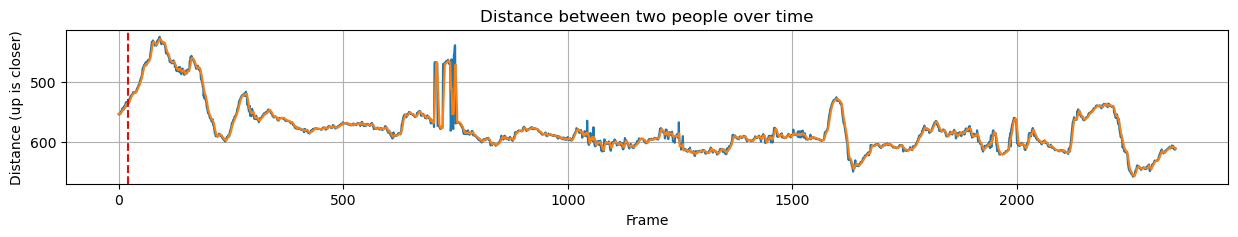

In [36]:
# plot the distance
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import cv2

# Load a CSV file with distance data using glob
distance_data = pd.read_csv(glob.glob(outputfol + '*processed_data*.csv')[0])

# make a function out of this
def plot_distance(distance_data, frame, show = False):
    """Plot the distance as timeseries with x axis frames and y axis distance with flipped axes.
    Also plot a vertical line at the given frame number, and return the plot."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=distance_data, x='frame', y='distance')
    sns.lineplot(data=distance_data, x='frame', y='distance_smooth')
    plt.xlabel('Frame')
    plt.ylabel('Distance')
    plt.title('Distance between two people over time')
    plt.grid()
    plt.axvline(x=frame, color='r', linestyle='--')
    # flip the y axis (up is closer)
    plt.gca().invert_yaxis()
    # add a note on the y label
    plt.ylabel('Distance (up is closer)')
    # make the image much broader than taller
    plt.gcf().set_size_inches(15, 2)
    if show == True:
        plt.show()
    # render plot immediately to an imgae
    imageplot = plt.gcf()
    plt.close()
    return imageplot

test = plot_distance(distance_data, 20, show = True)


Note of course, that is is now not difficult to just load a file and compute summary statistics for this particular video (or trial). 

the mean distance: 578.9680974064145
standard deviation:  40.39701763935418


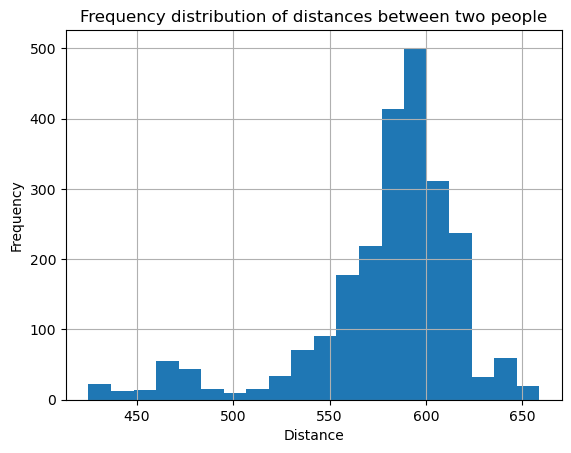

In [37]:
import pandas as pd

# Load a CSV file with distance data using glob
distance_data = pd.read_csv(glob.glob(outputfol + '*processed_data*.csv')[0])

# computing some relevant summary statistcs (mean, sd, and frequency distribution)
mean_distance = distance_data['distance'].mean()
sd_distance = distance_data['distance'].std()
distance_data['distance'].plot.hist(bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Frequency distribution of distances between two people')
plt.grid()
print('the mean distance:',  mean_distance)
print('standard deviation: ', sd_distance)

In the following chunk, we loop over each frame of the tracked video, and then we generate a figure with the vertical bar at the precise frame number, and plot the timeseries plot onto the video (in the lower region). In this way we can show the changing social proximity.

In [12]:
import tqdm

#check all videos with layer 1
allvidsnew = glob.glob(outputfol + '*_layer1.mp4')

# make an annimation
for vids, vidsnew in zip(allvids, allvidsnew):
    vidname = os.path.basename(vids)
    vidname = vidname[:-4]
    # Load the CSV file
    distance_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer1.csv')
    # load the video file in opencv
    cap = cv2.VideoCapture(vidsnew)
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Define the output video writer
    output_path = outputfol + '/' + vidname + '_distance_layer1.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    # loop over the frames with tqdm processbar
    frame_count = 0
    for _ in tqdm.tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # read the frame
        success, frame = cap.read()
        if not success:
            break
        # plot the distance
        plot = plot_distance(distance_data, frame_count)
        # save the plot to a temp file in the output folder
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False, dir=outputfol) as f:        
            plot.savefig(f.name)
            plot_img = cv2.imread(f.name)
            # resize the plot image to the size of the frame
            plot_img = cv2.resize(plot_img, (width, int(height/3)))
            # add the plot image to the frame
            frame[2*int(height/3):, :, :] = plot_img
            # write the frame to the output video
            # downsize the video by a half
            out.write(frame)
                 
        frame_count += 1
    # Release everything
    cap.release()
    out.release()
    print(f"Output video saved as {output_path}")
    # delete all temp files
    for file in glob.glob(outputfol + '/*.png'):
        os.remove(file)

  0%|          | 0/2354 [00:00<?, ?it/s]100%|██████████| 2354/2354 [06:38<00:00,  5.90it/s] 


Output video saved as ./output//TestVideo_distance_layer2.mp4
